In [1]:
from frgpascal.system import build, ALL_WORKERS
from roboflo import System

Generate protocols

In [2]:
from frgpascal.experimentaldesign.tasks import *

In [3]:
absorber_solution = Solution(
        solutes= 'FA0.78_Cs0.22_(Pb_(I0.9_Br0.1)3)1.09',
        solvent= 'DMF3_DMSO1',
        molarity= 1.25,
    )

In [4]:
methyl_acetate = Solution(
        solvent='MethylAcetate',
        labware='4mL_b_AntisolventTray',
        well='D1',
    )

In [5]:
spincoat_absorber = Spincoat(
        steps=[
            [3000,2000,50], #speed (rpm), acceleration (rpm/s), duration (s)
        ],
        drops = [
            Drop(
                solution=absorber_solution,  #this will be filled later using the list of psk solutions
                volume=20,
                time=-1,
                blow_out=True,
                # pre_mix = (5,50),
            ),
            Drop(
                solution=methyl_acetate,
                volume=50,
                time=22,
                reuse_tip=True,
                touch_tip=False,
                rate=100,
                pre_mix = (3,100),
                slow_travel=True
            )
        ],
    )

In [6]:
anneal_absorber = Anneal(
        temperature=100, #degrees C
        duration=30*60, #seconds
        hotplate='Hotplate1'
    )

anneal_absorber2 = Anneal(
        temperature=125, #degrees C
        duration=30*60, #seconds
        hotplate='Hotplate2'
    )

anneal_passivation = Anneal(
        temperature=50, #degrees C
        duration=30*60, #seconds
        hotplate='Hotplate3'
    )

In [9]:
s1 = Sample(
    name='sample0',
    substrate='glass',
    worklist = [
        spincoat_absorber,
        anneal_absorber,
        Rest(180),
        Characterize()
    ],
    storage_slot = {'tray':'Tray1', 'slot':'A1'},
)

In [10]:
s2 = Sample(
    name='sample3',
    substrate='glass',
    worklist = [
        spincoat_absorber,
        anneal_absorber,
        Rest(180),
        Characterize()
    ],
    storage_slot = {'tray':'Tray1', 'slot':'A1'},
)

In [11]:
def class_to_worker(worker_class):
    for w in ALL_WORKERS.values():
        if isinstance(w, worker_class):
            return w
    raise Exception("Could not find a matching worker for class {}".format(worker_class))

def generate_protocol(sample:Sample, system:System, min_start:int = 0):
    tray = [w for w in system.workers if isinstance(w, Worker_Storage) and w.name == sample.storage_slot['tray']][0]
    hotplate = [w for w in system.workers if isinstance(w, Worker_Hotplate) and w.name == task.hotplate][0]
    # print(hotplate)

    for task in sample.worklist:
        corrected_workers = []
        for worker in task.workers:
            if worker in ALL_WORKERS.values():
                corrected_workers.append(worker)
            elif worker == Worker_Hotplate:
                corrected_workers.append([w for w in system.workers if isinstance(w, Worker_Hotplate) and w.name == task.hotplate][0])
            elif worker == Worker_Storage:
                corrected_workers.append(tray)
            else:
                corrected_workers.append(class_to_worker(worker))
        task.workers = corrected_workers
        task.sample = sample.name

    sample.protocol = system.generate_protocol(
        name=sample.name,
        worklist=sample.worklist,
        starting_worker=tray,
        ending_worker=tray,
        min_start = min_start
    )

In [12]:
pascal = build()

In [13]:
generate_protocol(sample=s1, system=pascal)
generate_protocol(sample=s2, system=pascal)

AttributeError: 'Sample' object has no attribute 'hotplate'

In [51]:
pascal.scheduler.solve(enforce_protocol_order=False)

previous solution still valid - add new protocols before solving again


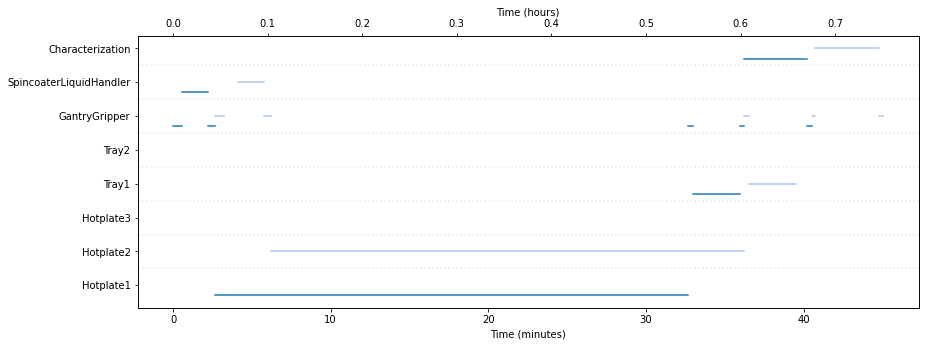

In [52]:
pascal.scheduler.plot_solution()